<a href="https://colab.research.google.com/github/antran28/Build-Decision-Tree-Classification-from-Scratch/blob/main/Build_Decision_Tree_Classification_ML_From_Scracth.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Theory of Classification Decision Trees**:
A classification decision tree is a supervised machine learning algorithm used for both
classification and regression tasks. In a classification decision tree:

**Nodes and Edges**: The tree is composed of nodes and edges. Each node represents a decision or a test on a feature, and each edge represents the outcome of that test.

**Root Node**: The topmost node in the tree is called the root node. It represents the entire dataset.

**Internal Nodes**: Nodes other than the root node are called internal nodes. They represent decisions based on specific features.

**Leaf Nodes**: Terminal nodes at the bottom of the tree are called leaf nodes or decision nodes. They contain the predicted class label or value for a data point.

**Splitting Criteria**: At each internal node, the dataset is split into two or more subsets based on a splitting criterion. For classification, common criteria are Gini impurity and entropy. For regression, Mean Squared Error (MSE) is often used.

**Recursive Splitting**: The process of recursively splitting the dataset continues until a stopping criterion is met. This may include reaching a specified tree depth, having too few data points in a node, or achieving pure leaf nodes (all data points in a leaf node belong to the same class).

**Prediction**: To make a prediction for a new data point, it traverses the tree from the root to a leaf node by following the decisions at each internal node. The predicted class label is the majority class in the leaf node (for classification tasks).

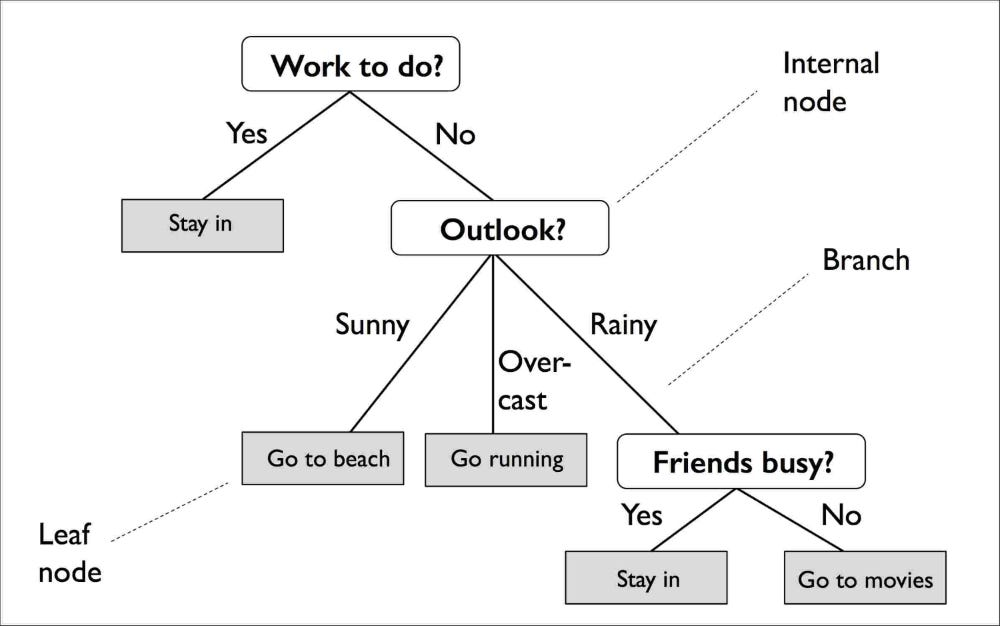

**1. Import library**

In [ ]:
import numpy as np
import seaborn as sns
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

sns.set()
%config InlineBackend.figure_format = 'retina'

**2. Define splitting criterion parameter**

'entropy(y)' and 'gini(y)' functions are defined to calculate the impurity of a set of class labels. These functions are used as criteria for splitting the data.

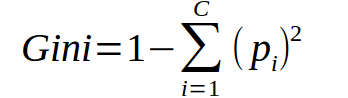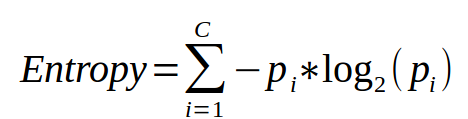

In [ ]:
# Define entropy and gini impurity functions
def entropy(y):
    _, counts = np.unique(y, return_counts=True)
    probabilities = counts / len(y)
    return -np.sum(probabilities * np.log2(probabilities + 1e-10))

def gini(y):
    _, counts = np.unique(y, return_counts=True)
    probabilities = counts / len(y)
    return 1 - np.sum(probabilities**2)

**3. Criteria Dictionary**

A dictionary called criteria_dict is created to map criterion names to the corresponding impurity functions. This allows the user to select either "entropy" or "gini" as the impurity criterion.

In [ ]:
criteria_dict = {
    "entropy": entropy,
    "gini": gini,
}

**4. Build 'Node' for the Decision Tree**

The Node class represents a node in the decision tree. It has attributes for feature index, threshold, labels (class labels for the data points in the node), and references to left and right child nodes.

In [ ]:
class Node:
    def __init__(self, feature_idx=None, threshold=None, labels=None, left=None, right=None):
        self.feature_idx = feature_idx
        self.threshold = threshold
        self.labels = labels
        self.left = left
        self.right = right

**5. Assign class lables for a leaf node in decision tree**

The code in the classification_leaf function assigns the class label for a leaf node in a decision tree. When instances reach a leaf node during the tree traversal, the leaf node needs to predict their class label. To do this, it considers all the instances that have reached that leaf node, and it assigns the class label that is most common among those instances.

In [ ]:
def classification_leaf(y):
    return np.bincount(y).argmax()

**6. Define the decision tree model with classification tasks with configurable parameters**

The DecisionTree class encapsulates the decision tree model and its operations.

- The constructor ***__init__*** allows the user to set hyperparameters like max_depth, min_samples_split, and criterion. It also initializes the selected criterion function and leaf value function.

- ***_functional*** calculates the impurity reduction (functional) for a potential split. It is used to find the best feature and threshold for splitting.

- ***_build_tree*** is a recursive method for constructing the decision tree. It follows the process of finding the best split and recursively building child nodes.

- ***fit*** is the method to fit the decision tree to the training data. It initializes the tree and calls _build_tree to construct it.

- ***predict_one*** is used to predict a single data point's class label by traversing the decision tree.

- ***predict*** applies predict_one to make predictions for multiple data points.

In [ ]:
class DecisionTree:
    def __init__(self, max_depth=np.inf, min_samples_split=2, criterion="gini"):
        # Initialization: Define hyperparameters and criterion function
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.criterion = criterion
        self._criterion_function = criteria_dict[criterion]  # Choose Gini or Entropy as the impurity measure
        self._leaf_value = classification_leaf  # Assign class labels to leaf nodes

    def _functional(self, X, y, feature_idx, threshold):
        # Calculate the impurity reduction for a potential split
        left_mask = X[:, feature_idx] < threshold
        right_mask = ~left_mask
        left_y = y[left_mask]
        right_y = y[right_mask]
        n_obj = X.shape[0]
        n_left = np.sum(left_mask)
        n_right = n_obj - n_left
        if n_left > 0 and n_right > 0:
            return (
                self._criterion_function(y)
                - (n_left / n_obj) * self._criterion_function(left_y)
                - (n_right / n_obj) * self._criterion_function(right_y)
            )
        else:
            return 0

    def _build_tree(self, X, y, depth=1):
        # Recursively build the decision tree
        n_samples, n_features = X.shape

        if len(np.unique(y)) == 1:
            return Node(labels=y)

        if depth >= self.max_depth or n_samples < self.min_samples_split:
            return Node(labels=y)

        max_criterion_value = -float('inf')
        best_split = None

        for feature_idx in range(n_features):
            thresholds = np.unique(X[:, feature_idx])

            for threshold in thresholds:
                criterion_value = self._functional(X, y, feature_idx, threshold)

                if criterion_value > max_criterion_value:
                    max_criterion_value = criterion_value
                    best_split = {
                        'feature_idx': feature_idx,
                        'threshold': threshold
                    }

        if best_split is not None:
            left_mask = X[:, best_split['feature_idx']] < best_split['threshold']
            right_mask = ~left_mask
            left_subtree = self._build_tree(X[left_mask], y[left_mask], depth + 1)
            right_subtree = self._build_tree(X[right_mask], y[right_mask], depth + 1)
            return Node(
                feature_idx=best_split['feature_idx'],
                threshold=best_split['threshold'],
                left=left_subtree,
                right=right_subtree
            )
        else:
            return Node(labels=y)

    def fit(self, X, y):
        # Fit the decision tree to the training data
        self.root = self._build_tree(X, y)

    def predict_one(self, node, X):
        # Recursively predict the class label for one data point
        if node.labels is not None:
            return self._leaf_value(node.labels)
        if X[node.feature_idx] < node.threshold:
            return self.predict_one(node.left, X)
        else:
            return self.predict_one(node.right, X)

    def predict(self, X):
        # Predict class labels for a set of data points
        return [self.predict_one(self.root, x) for x in X]


## **Testing the implemented algorithm**

**Testing using the 'make_classification' dataset**

In [ ]:
from sklearn.datasets import (
    load_digits,
    make_classification,
    make_regression,
)

Accuracy: 0.85


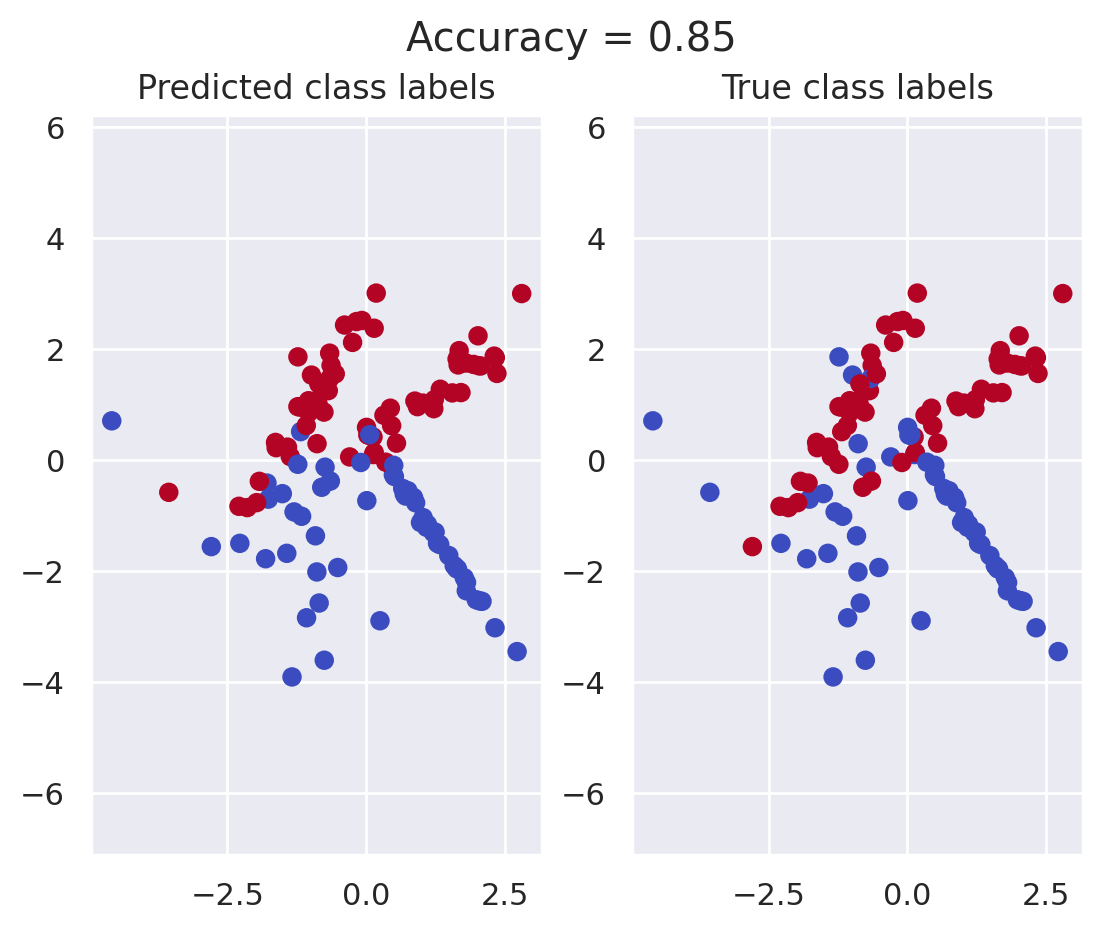

In [ ]:
# Generate a make_classification dataset
X, y = make_classification(
    n_features=2, n_redundant=0, n_samples=400, random_state=17
)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=17
)

# Create and fit the decision tree model
clf = DecisionTree(max_depth=4, criterion="gini")
clf.fit(X_train, y_train)

# Make predictions
y_pred = clf.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Plot the results
plt.suptitle("Accuracy = {:.2f}".format(accuracy))
plt.subplot(121)
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_pred, cmap=plt.cm.coolwarm)
plt.title("Predicted class labels")
plt.axis("equal")
plt.subplot(122)
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=plt.cm.coolwarm)
plt.title("True class labels")
plt.axis("equal")
plt.show()

**Testing using the 'Iris' dataset**

Accuracy: 0.9333333333333333


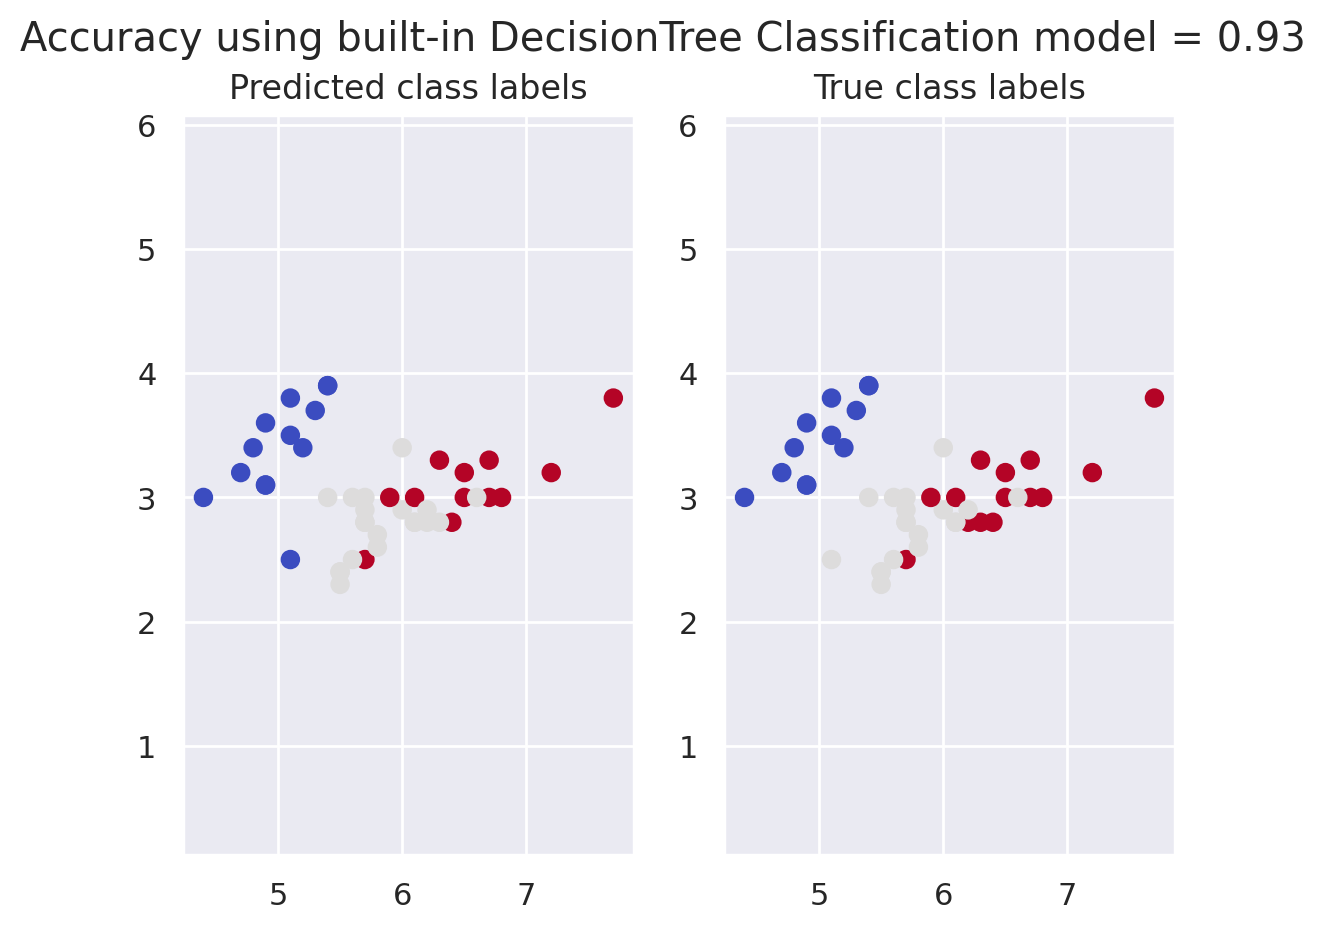

In [ ]:
import graphviz
from sklearn.datasets import load_iris
from sklearn.tree import export_graphviz

# Load the Iris dataset
iris = load_iris()
X = iris.data
y = iris.target

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=17
)

# Create and fit the decision tree model
clf = DecisionTree(max_depth=4, criterion="gini")
clf.fit(X_train, y_train)

# Make predictions
y_pred = clf.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Plot the results
plt.suptitle("Accuracy using built-in DecisionTree Classification model = {:.2f}".format(accuracy))
plt.subplot(121)
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_pred, cmap=plt.cm.coolwarm)
plt.title("Predicted class labels")
plt.axis("equal")
plt.subplot(122)
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=plt.cm.coolwarm)
plt.title("True class labels")
plt.axis("equal")
plt.show()

Accuracy: 0.9777777777777777


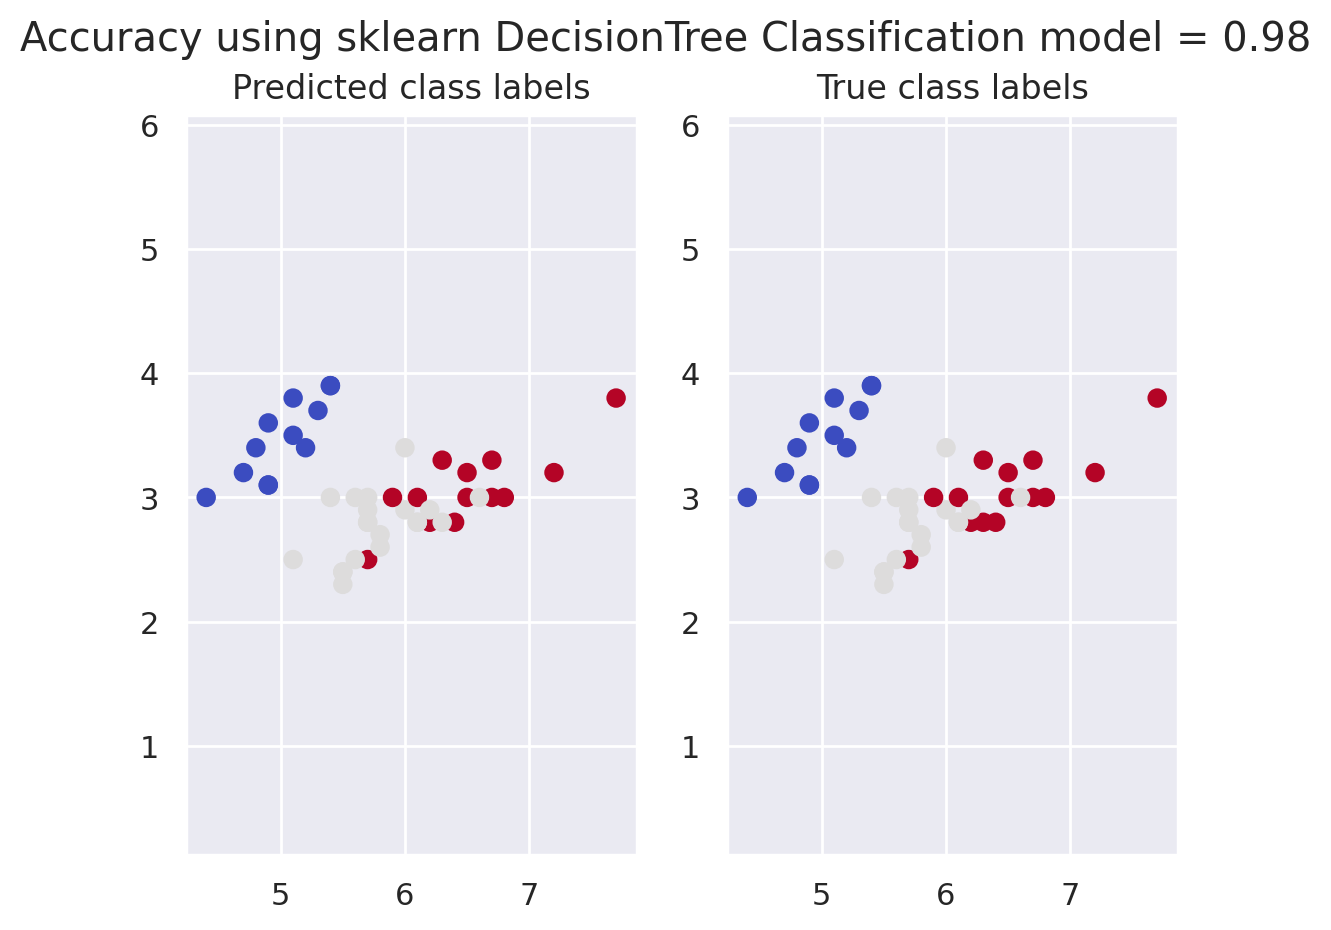

In [ ]:
import graphviz
from sklearn.datasets import load_iris
from sklearn.tree import export_graphviz, DecisionTreeClassifier, plot_tree
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Load the Iris dataset
iris = load_iris()
X = iris.data
y = iris.target

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=17
)

# Create and fit a new DecisionTreeClassifier model
clf = DecisionTreeClassifier(max_depth=4, criterion="gini")
clf.fit(X_train, y_train)

# Make predictions
y_pred = clf.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Plot the results (from your previous code)
plt.suptitle("Accuracy using sklearn DecisionTree Classification model = {:.2f}".format(accuracy))
plt.subplot(121)
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_pred, cmap=plt.cm.coolwarm)
plt.title("Predicted class labels")
plt.axis("equal")
plt.subplot(122)
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=plt.cm.coolwarm)
plt.title("True class labels")
plt.axis("equal")
plt.show()